# Pipeline to remove Camponotus planatus (Cpla) contamination from Odontomachus ruginodis (Orug) transcriptome
This takes single gene phylogenies as input, along with the transcriptomes and other stuff

## Table of Contents

1. Find genes in Orug that have >90% blast similarity to a gene in Cpla
2. Find their peptide sequences (MAGGGOT), find their best hit in 11 other Apoidea (BLASTP), align (MAFFT), and build ML phylogenies (RAxML)
3. Read in trees and analyse
4. Construct dataframe with sequence and phylogenetic features
5. Plots showing that these features indicate contamination
6. Identify and remove contaminants from the transcriptome
7. Remove contaminant sequences from the htseq counts files

In [2]:
import itertools
import os

In [3]:
from Bio import SeqIO
from ete3 import Tree

In [4]:
import numpy as np
import pandas as pd

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Find genes in Orug that have >90% blast similarity to a gene in Cpla

In [6]:
blast_cols = ['qseqid', 'sseqid', 'pident', 'length', 'mismatch', 'gapopen', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']

#Read in blast output table of whole Orug transcriptome blastp'd against whole Cpla transcriptome
df_Orug_vs_Cpla = pd.read_csv(os.path.join("contamination_assessment","Orug_vs_Cpla.txt"), 
                              header=None,
                              sep='\t',
                              names=blast_cols,
                             )
df_Orug_vs_Cpla.head()

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
0,Orug|SGF62645,Cpla|SGF49990,100.00,104,0,0,1,104,517,620,5.000000e-68,219.0
1,Orug|SGF62647,Cpla|SGF48983,100.00,15,0,0,105,119,22,36,2.000000e-03,35.0
2,Orug|SGF62648,Cpla|SGF59801,86.18,340,13,3,1,308,23,360,0.000000e+00,545.0
3,Orug|SGF62649,Cpla|SGF51865,29.41,68,42,1,48,115,96,157,4.700000e+00,25.8
4,Orug|SGF65438,Cpla|SGF57541,27.63,76,55,0,45,120,2964,3039,2.100000e+00,27.3


In [7]:
#find Orug genes with >90% identity to Cpla
s_Orug_candidates = df_Orug_vs_Cpla[df_Orug_vs_Cpla.pident > 90]['qseqid']

print('{} Orug genes with >90% identity to their best hit in Cpla, from {} total Orug genes.'.format(
    len(s_Orug_candidates),
    len(df_Orug_vs_Cpla)
    ))
s_Orug_candidates.head()

3522 Orug genes with >90% identity to their best hit in Cpla, from 25621 total Orug genes.


0     Orug|SGF62645
1     Orug|SGF62647
7     Orug|SGF62652
35    Orug|SGF62674
40    Orug|SGF62679
Name: qseqid, dtype: object

## 2. Find their peptide sequences (MAGGGOT), find their best hit in 11 other Apoidea (BLASTP), align (MAFFT), and build ML phylogenies (RAxML)

The best BLAST result for each of these resultant Orug candidate genes from a range of Hymenoptera was determined.

In [8]:
# create dictionary of blast results
sp_list = ['Aech', 'Amel', 'Bimp', 'Cpla', 'Cflo', 'Dqua', 'Hsal', 'Lnig', 'Mrot', 'Obir', 'Sinv']
fp_list = ["contam_Orug_vs_{}.bx".format(x) for x in sp_list ]
           
sp_blast = { sp:pd.read_csv(os.path.join("contamination_assessment",fp), 
                            header=None, 
                            names=blast_cols,
                            sep='\t',
                           ) for sp,fp in zip(sp_list, fp_list)}

In [9]:
sp_blast['Amel'].head()

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
0,Orug|SGF62645,Amel|LOC411540,98.08,104,2,0,1,104,517,620,8.000000e-67,215.0
1,Orug|SGF62647,Amel|LOC411273,32.43,37,25,0,47,83,199,235,3.000000e+00,26.9
2,Orug|SGF62652,Amel|LOC551967,87.42,310,38,1,1,310,1,309,0.000000e+00,571.0
3,Orug|SGF62674,Amel|Iscu,86.13,137,19,0,14,150,14,150,1.000000e-84,248.0
4,Orug|SGF62679,Amel|LKR,80.50,200,39,0,1,200,719,918,2.000000e-109,336.0


In [10]:
# get all genes with an evalue match < 0.01
df_concat1 = pd.concat([sp_blast[sp][sp_blast[sp]['evalue'] < 0.01] for sp in sp_list], axis=0)

In [11]:
df_orug_hits = df_concat1.pivot_table(values='sseqid', 
                                       index='qseqid', 
                                       aggfunc=lambda x: list(x)
                                      )

/Users/poxley/anaconda3/envs/bioinformatics/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


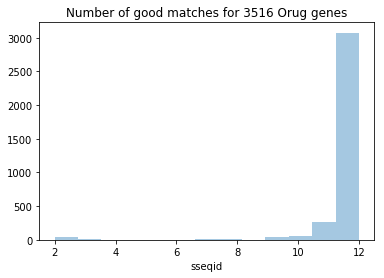

In [12]:
sns.distplot(df_orug_hits.sseqid.apply(lambda s: len(s)+1), kde=False, bins=13)
plt.title("Number of good matches for {} Orug genes".format(len(df_orug_hits)))
plt.show()

The above figure shows that most of the candidate contaminant genes have a good match from all of the reference genomes.

In [17]:
#save lists of Orug orthologue groups; one group per file
for ogene in df_orug_hits.index:
    handle = open('{}.out'.format(ogene), 'w')
    handle.write('\n'.join(df_orug_hits.loc[ogene].values))

Used mafft and raxml on the server to construct phylogenies for each of these orthologue groups (scripts attached below); analysis continues here. 

### MAGGGOT Script
```
#!/usr/bin/bash

for i in $(cat 'Orug_candidate_seqs.txt'); do 

    MAGOT get_seq_from_fasta '../Orug_trinity.pep' $i True >> Orug_candidate_seqs.fasta 

done
```

### MAFFT Script
```
#!/usr/bin/bash

for i in $(ls 'Orug_candidates/Orug_sequences/'); do

   mafft --localpair --thread 30 --maxiterate 1000 Orug_candidates/Orug_sequences/$i > $i.aligned

done
```

### RAxML Script
```
#!/usr/bin/bash

for i in $(ls 'Orug_candidates/alignments/'); do

    raxml -s Orug_candidates/alignments/$i -m PROTGAMMAJTT -p 6666 -T 30 -n $i.out 

done
```

## 3. Read in trees and analyse

In [13]:
#list all Orug trees in treelist
treelist = []
for file in os.listdir('contamination_assessment/Orug_trees/'):
    if 'bestTree' in file:
        treelist.append('contamination_assessment/Orug_trees/' + file)

print(len(treelist))

3469


In [14]:
#print examples of these phylogenies
for i in range(0, 2):
    x = Tree(treelist[i])
    print(x)


         /-Cbir|LOC105285907
        |
      /-|      /-Cpla|SGF56824
     |  |   /-|
     |  |  |   \-Cflo|XP_011260747.1
     |   \-|
   /-|     |   /-Orug|SGF66875
  |  |      \-|
  |  |         \-KMQ93665.1
  |  |
  |  |   /-Sinv|XP_011159147.1
  |   \-|
  |     |   /-Dqua|LOC106746720
  |      \-|
--|         \-Hsal|LOC105187517
  |
  |   /-Mrot|XP_003706718.1
  |--|
  |  |   /-Bimp|XP_003487350.1
  |   \-|
  |      \-Amel|LOC408372
  |
   \-Aech|XP_011062839.1

   /-Sinv|XP_011169572.1
  |
  |      /-Cbir|LOC105275518
  |     |
  |   /-|   /-Dqua|LOC106742533
  |  |  |  |
  |  |   \-|      /-Orug|SGF64046
  |  |     |   /-|
  |  |      \-|   \-Cpla|SGF48456
  |--|        |
  |  |         \-Hsal|LOC105191572
--|  |
  |  |   /-KMQ96987.1
  |  |  |
  |  |  |         /-Bimp|XP_003488371.1
  |   \-|      /-|
  |     |   /-|   \-Mrot|XP_003706904.1
  |     |  |  |
  |      \-|   \-Amel|LOC550651
  |        |
  |         \-Cflo|XP_011258337.1
  |
   \-Aech|XP_011066661.1


In [15]:
# for each tree in the list, ask whether Cpla is sister to Orug. 
# store names of possible contaminant sequences
# store distances between Orug and Cpla in separate files; one for good trees and one for possible contaminants
# plot distributions of these distances

contaminants = {}
good_genes = {}
s_clade = {}
bee_tree_errors = []
no_bees = []
weird_bees = []
s_clade_errors = []
bee_seq_errors = []
scl1 = 0
nobiroi = []
fail = []
sis_clade_fail = []


for tree in treelist:
    Cpla = ''
    Orug = ''
    Cflo = ''
    Lnig = ''
    Hsal = ''
    Dqua = ''
    Mrot = ''
    Amel = ''
    Bimp = ''
    x = ''
    sis_clade = ''
    bee_ancestor = []
    bad = False

    intree = Tree(tree)
    for leaf in intree: 
        if 'Mrot' in leaf.name:
            Mrot = leaf.name
        elif 'Amel' in leaf.name:
            Amel = leaf.name
        elif 'Bimp' in leaf.name:
            Bimp = leaf.name
        elif 'Cbir' in leaf.name:
            Obir = leaf.name
    
    #find bees
    nbees = []
    for i in [Mrot, Amel, Bimp]:
        if i != '':
            nbees.append(i)
    
    #find ancestor of all bees
    try:
        if len(nbees) > 1:
            bee_ancestor = intree.get_common_ancestor(nbees)
        elif len(nbees) == 1:
            bee_ancestor = [nbees[0]]
        else:
            no_bees.append(tree)
    except:
        bee_seq_errors.append(tree)
        continue
    
    #reroot tree on ancestral bee (allow bee clade to contain up to one non-bee and if not, try rooting on any one bee. 
    # If this also fails, try rooting on biroi. Catch exceptions in nobiroi and go to next tree)
    if len(bee_ancestor) <= 4 and len(bee_ancestor) > 1:
        intree.set_outgroup(bee_ancestor)
    elif len(bee_ancestor) > 4 or len(bee_ancestor) == 1:
        intree.set_outgroup(nbees[0])
        weird_bees.append(tree)
    elif len(bee_ancestor) == 0:
        try:
            intree.set_outgroup(Obir)
        except:
            nobiroi.append(tree)
            bad = True
    
    if not bad:
        for leaf in intree:
            if 'Cpla' in leaf.name:
                Cpla = leaf.name
            elif 'Orug' in leaf.name:
                Orug = leaf.name
            elif 'Hsal' in leaf.name:
                Hsal = leaf.name
            elif 'KM' in leaf.name:
                Lnig = leaf.name
            elif 'Dqua' in leaf.name:
                Dqua = leaf.name
            elif 'Cflo' in leaf.name:
                Cflo = leaf.name
                
                

        if len(Cpla) > 0: 
            x = str(tree)
            x = x.split('.')
            x = x[1]
            cont_check = intree.get_common_ancestor(Cpla, Orug)
            if len(cont_check) == 2:
                contaminants[x] = intree.get_distance(Cpla, Orug)
            elif len(cont_check) > 2:
                good_genes[x] = intree.get_distance(Cpla, Orug)
            sis_clade = cont_check.get_sisters()
            
            if sis_clade != '':
                if Lnig != '' and Cflo != '' and Dqua != '' and Hsal != '':
                    Hmrca = intree.get_common_ancestor(cont_check, Hsal)
                    Dmrca = intree.get_common_ancestor(cont_check, Dqua)
                    Cmrca = intree.get_common_ancestor(cont_check, Cflo)
                    Lmrca = intree.get_common_ancestor(cont_check, Lnig)
                    Pav = min(len(Hmrca), len(Dmrca))
                    Fav = min(len(Cmrca), len(Lmrca))
                
                    #check if Orug is in ponerine or formicine clade
                    if len(sis_clade) == 1:
                        if Pav > Fav:
                            s_clade[x] = 'F'
                        elif Pav < Fav:
                            s_clade[x] = 'P'
                        else:
                            if len(cont_check) == 2:
                                s_clade[x] = 'both'
                                sis_clade_fail.append(tree)
                        scl1 += 1
                else: 
                    s_clade_errors.append(x)    
                
            
    else: 
        fail.append(tree)
    


In [16]:
df_results = pd.Series({'Trees with no bees and no O. biroi sequences: ' : str(len(nobiroi)),
                        'failures: ' : str(len(fail)),
                        'Trees with no bees: ' : str(len(no_bees)),
                        'Possible contaminants: ' : str(len(contaminants)),
                        'Good genes: ' : str(len(good_genes)),
                        'Successful classification of clade: ' : str(len(s_clade)),
                        'Bee sequence errors: ' : str(len(bee_seq_errors)),
                        'Bee tree errors: ' : str(len(bee_tree_errors)),
                        'Weird bees: ' : str(len(weird_bees)),
                        'Clade classification errors: ' : str(len(s_clade_errors)),
                       })

print(scl1)
print(len(sis_clade_fail))
df_results

3184
10


Bee sequence errors:                                 0
Bee tree errors:                                     0
Clade classification errors:                       253
Good genes:                                       2940
Possible contaminants:                             522
Successful classification of clade:                805
Trees with no bees and no O. biroi sequences:        5
Trees with no bees:                                 43
Weird bees:                                        330
failures:                                            5
dtype: object

In [17]:
#define true species tree
truetree = Tree("(((Dqua,(Orug, Hsal)),(Obir,((Lnig,(Cflo, Cpla)),(Aech, Sinv)))),(Mrot, (Amel, Bimp)));")

#make dictionary with Robinson-Foulds distances between each tree and the true species tree

rfs = {}
bee_tree_errors2 = []
bee_seq_errors2 = []

for tree in treelist:
    Cpla = []
    Orug = []
    Cflo = []
    Lnig = []
    Hsal = []
    Dqua = []
    Obir = []
    Amel = []
    Mrot = []
    Bimp = []
    Sinv = []
    Aech = []

    intree = Tree(tree)
    for leaf in intree: 
        if 'Mrot' in leaf.name:
            Mrot = leaf.name
        elif 'Amel' in leaf.name:
            Amel = leaf.name
        elif 'Bimp' in leaf.name:
            Bimp = leaf.name
        elif 'Orug' in leaf.name:
            Orug = leaf.name
   
    nbees = []
    for i in [Mrot, Amel, Bimp]:
        if i != '':
            nbees.append(i)
    
    try:
        bee_ancestor = intree.get_common_ancestor(nbees)
    except:
        bee_seq_errors2.append(tree)
        continue
        
    if len(bee_ancestor) <= 4 and len(bee_ancestor) > 0:
        intree.set_outgroup(bee_ancestor)
    else:
        bee_tree_errors2.append(tree)
    
    if len(bee_ancestor) <= 4 and len(bee_ancestor) > 0:
        for leaf in intree:
            if 'Cpla' in leaf.name:
                leaf.name = 'Cpla'
            elif 'Orug' in leaf.name:
                leaf.name = 'Orug'
            elif 'Hsal' in leaf.name:
                leaf.name = 'Hsal'
            elif 'KM' in leaf.name:
                leaf.name = 'Lnig'
            elif 'Dqua' in leaf.name:
                leaf.name = 'Dqua'
            elif 'Cflo' in leaf.name:
                leaf.name = 'Cflo'
            elif 'Cbir' in leaf.name:
                leaf.name = 'Obir'
            elif 'Aech' in leaf.name:
                leaf.name = 'Aech'
            elif 'Sinv' in leaf.name:
                leaf.name = 'Sinv'
            elif 'Amel' in leaf.name:
                leaf.name = 'Amel'
            elif 'Bimp' in leaf.name:
                leaf.name = 'Bimp'
            elif 'Mrot' in leaf.name:
                leaf.name = 'Mrot'
        
        a = truetree.robinson_foulds(intree)
        normrf = float(a[0])/float(a[1])
        rfs[Orug] = float(normrf)

In [18]:
print(len(rfs))

2993


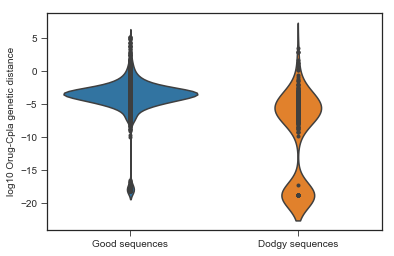

In [25]:
#plot tree distance for good sequences and potential contaminants (i.e. dodgy sequences)
sns.set_style('ticks')

lgd = [np.log2(x) for x in good_genes.values()]    
lbd = [np.log2(x) for x in contaminants.values()]    

aa = sns.violinplot(data=[lgd, lbd], scale='area', inner='point')
aa.set(ylabel = 'log10 Orug-Cpla genetic distance')
aa.set_xticklabels(['Good sequences', 'Dodgy sequences'])

plt.show()

## 4. Construct dataframe with sequence and phylogenetic features

In [26]:
#read in outputs for blastp of Orug against Cpla and two formicines
Orug_vs_Cpla = pd.read_csv("contamination_assessment/Orug_vs_Cpla.txt", header = None, sep='\t', names=blast_cols)
Orug_vs_Lnig = pd.read_table("contamination_assessment/Orug_vs_Lnig.bx", header = None, sep='\t', names=blast_cols)
Orug_vs_Cflo = pd.read_table("contamination_assessment/Orug_vs_Cflo.bx", header = None, sep='\t', names=blast_cols)

In [27]:
Orug_vs_Cpla.head()

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
0,Orug|SGF62645,Cpla|SGF49990,100.00,104,0,0,1,104,517,620,5.000000e-68,219.0
1,Orug|SGF62647,Cpla|SGF48983,100.00,15,0,0,105,119,22,36,2.000000e-03,35.0
2,Orug|SGF62648,Cpla|SGF59801,86.18,340,13,3,1,308,23,360,0.000000e+00,545.0
3,Orug|SGF62649,Cpla|SGF51865,29.41,68,42,1,48,115,96,157,4.700000e+00,25.8
4,Orug|SGF65438,Cpla|SGF57541,27.63,76,55,0,45,120,2964,3039,2.100000e+00,27.3


In [28]:
colnames = ['baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue', 'padj']
Cpla_deseq = pd.read_csv("contamination_assessment/Camp_planatus.genes.QW.pvalues.nohed.out", 
                         sep = ' ', header=None,
                         names=colnames,
                        )

Orug_deseq = pd.read_csv("contamination_assessment/Odontomachus.genes.QW.pvalues.nohed.out", 
                         sep = ' ', header=None,
                         names=colnames,
                        )
Orug_deseq.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Orug|SGF82787,2400.887711,-2.557067,0.168923,-15.137451,9.169985e-52,1.387602e-47
Orug|SGF63944,600.445549,-3.010519,0.215700,-13.956944,2.854124e-44,2.159430e-40
Orug|SGF61220,2092.490625,-2.957865,0.213546,-13.851192,1.251180e-43,6.310950e-40
Orug|SGF64259,761.007066,-3.751297,0.274955,-13.643294,2.213327e-42,8.373017e-39
Orug|SGF68061,194.643827,-2.377130,0.175826,-13.519819,1.194690e-41,3.031041e-38


### Create new table

In [30]:
df_genes = pd.DataFrame({'Orug_genes':s_Orug_candidates})

In [31]:
# join the Cpla blast values to the dataframe
df_genes = pd.merge(left=df_genes, right=Orug_vs_Cpla[['qseqid', 'sseqid','pident']], 
                     left_on='Orug_genes', right_on='qseqid', 
                     how='left'
                   )

In [32]:
# find lengths of each peptide sequence in the Orug and Cpla transcriptomes; save in dictionaries
Cpla_records = list(SeqIO.parse('contamination_assessment/Cpla_trinity.pep', 'fasta'))
Orug_records = list(SeqIO.parse('contamination_assessment/Orug_trinity.pep', 'fasta'))

s_Cpla_txome = pd.Series({str(record.name):str(record.seq) for record in Cpla_records}, name='Cpla_length')
s_Orug_txome = pd.Series({str(record.name):str(record.seq) for record in Orug_records}, name='Orug_length')

In [33]:
# append gene lengths
df_genes = df_genes.join(s_Cpla_txome.apply(len), on="sseqid")
df_genes = df_genes.join(s_Orug_txome.apply(len), on="qseqid")

In [34]:
# join the Cflo, Lnig blast values to the dataframe
df = Orug_vs_Cflo[['qseqid','pident']].rename({'pident':'pident_vs_Cflo'},axis=1)
df_genes = pd.merge(left=df_genes, right=df, 
                     left_on='qseqid', right_on='qseqid', 
                     how='left'
                   )

df = Orug_vs_Lnig[['qseqid','pident']].rename({'pident':'pident_vs_Lnig'},axis=1)
df_genes = pd.merge(left=df_genes, right=df, 
                     left_on='qseqid', right_on='qseqid', 
                     how='left'
                   )


In [35]:
# add mean expression of Cpla and Orug
for df,sp,col in zip([Cpla_deseq, Orug_deseq], ["Cpla", "Orug"], ['sseqid', 'qseqid']):
    df_genes = pd.merge(left=df_genes, right=df[['baseMean']], 
                         left_on=col, right_index=True, 
                         how='left'
                       ).rename({"baseMean":'{}_expressionlevel'.format(sp)}, axis=1)

In [36]:
# label contaminants and class fields
df_contaminants = pd.DataFrame({"genetic_distance":pd.Series(contaminants,),
                               "contaminated":1,
                              })

df_goodgenes = pd.DataFrame({"genetic_distance":pd.Series(good_genes),
                               "contaminated":0,
                               "class":"good",
                              })

# check there is no overlap in goodgene and contaminants lists:
print(len(df_contaminants.index.intersection(df_goodgenes.index)), "overlap in contaminant and good gene lists.")

df_concat = pd.concat([df_contaminants, df_goodgenes], axis=0)
df_concat.head(3)

0 overlap in contaminant and good gene lists.


,class,contaminated,genetic_distance
Orug|SGF60073,NaN,1,0.043391
Orug|SGF60090,NaN,1,0.046332
Orug|SGF60108,NaN,1,0.063843


In [37]:
df_genes = pd.merge(left=df_genes, right=df_concat, 
                     left_on='Orug_genes', right_index=True, 
                     how='left'
                   )

In [38]:
# add RF distance
df_genes = df_genes.join(on='Orug_genes', other=pd.Series(rfs, name="rfdistance"), how='left')

In [39]:
def get_normpident(s):
    """
    This function calculates ... ### This also is giving slightly different results, but I 
    can't understand the logic at this point of what it's trying to achieve ###
    """
    if s[["pident_vs_Lnig", "pident", "pident_vs_Cflo"]].count()==3:
        npd = s['pident'] / s[['pident_vs_Cflo','pident_vs_Lnig']].mean() 
    else: ### WHAT HAPPENS TO GENES WITHOUT A BLAST HIT FOR ONE OF LNIG/CFLO? ###
        npd = np.nan
    return npd

In [40]:
# get the normalized pident for Orug ... ### add details here ###
df_genes['normpident'] = df_genes.apply(get_normpident, axis=1)

In [41]:
# add distance classification for genes ... ### add details here ###
def get_dist_class(x):
    if np.log10(x) >= -4:
        return 0
    elif np.log10(x) < -4:
        return 1
    else:
        return np.nan

df_genes['dist_classification'] = df_genes.genetic_distance.apply(get_dist_class)

In [42]:
# set Orug expression of 0 to nan: ### WHY? ### 
df_genes.loc[df_genes.Orug_expressionlevel == 0,'Orug_expressionlevel'] = np.nan

In [43]:
# add the coefficient of variance for length and expression
def get_coef_vars(s):
    if s[['Cpla_length','Orug_length']].count() == 2:
        len_cfv = (s['Orug_length'] - s['Cpla_length']) / (s['Cpla_length'] + s['Orug_length'])
    else:
        len_cfv = np.nan
    if s[['Orug_expressionlevel', 'Cpla_expressionlevel']].count() == 2:
        exp_cfv = (s['Orug_expressionlevel'] - s['Cpla_expressionlevel']) / (s['Cpla_expressionlevel'] + s['Orug_expressionlevel'])
    else:
        exp_cfv = np.nan
    return pd.Series([len_cfv, exp_cfv])

df_genes[['len_coeff','exp_coeff']] = df_genes.apply(get_coef_vars, axis=1)

In [44]:
# add the sister taxa if given:
df_genes = df_genes.join(pd.Series(s_clade, name='ctd_sis_taxon'), on='Orug_genes', how='left')

In [45]:
def refine_verdict(s):
    if (s['contaminated'] == 1) and (s['ctd_sis_taxon'] == 'P'):
        clss = 'guilty'
    elif (s['contaminated'] == 1) and (s['ctd_sis_taxon'] == 'F' or s['ctd_sis_taxon'] == 'both'):
        clss = 'bad'
    else:
        clss = s['class']
    
    return clss
        
df_genes['class'] = df_genes.apply(refine_verdict, axis=1)

In [46]:
# adjust column names for clarity
df_genes = df_genes.rename({'pident':'pident_vs_Cpla',
                             'sseqid':'Cpla_genes',
                            },
                            axis=1,
                           )

In [47]:
df_genes.head()

,Orug_genes,qseqid,Cpla_genes,pident_vs_Cpla,Cpla_length,Orug_length,pident_vs_Cflo,pident_vs_Lnig,Cpla_expressionlevel,Orug_expressionlevel,class,contaminated,genetic_distance,rfdistance,normpident,dist_classification,len_coeff,exp_coeff,ctd_sis_taxon
0,Orug|SGF62645,Orug|SGF62645,Cpla|SGF49990,100.00,795,104,99.04,87.07,1477.909318,0.243665,bad,1.0,0.000002,0.7,1.074633,1.0,-0.768632,-0.999670,F
1,Orug|SGF62647,Orug|SGF62647,Cpla|SGF48983,100.00,108,143,34.09,34.38,0.752753,62.445599,NaN,NaN,NaN,NaN,2.920987,NaN,0.139442,0.976178,NaN
2,Orug|SGF62652,Orug|SGF62652,Cpla|SGF65473,96.36,220,313,95.81,40.08,0.745316,5.277055,good,0.0,0.132791,0.7,1.418206,0.0,0.174484,0.752484,NaN
3,Orug|SGF62674,Orug|SGF62674,Cpla|SGF48204,100.00,154,161,87.50,88.54,2.934701,6506.625398,guilty,1.0,0.000002,0.7,1.136105,1.0,0.022222,0.999098,P
4,Orug|SGF62679,Orug|SGF62679,Cpla|SGF63546,90.55,939,201,89.50,90.00,10.304242,0.163538,good,0.0,0.107483,0.2,1.008914,0.0,-0.647368,-0.968754,NaN


## 5. Plots showing that these features indicate contamination
The plots below show clearly that the phylogenetic classification identifies genes in Orug that have low expression, are very short, and have very low genetic distance to their best hit in Cpla. 
Moreover, the phylogenetic classification of the parent/sister clade of these likely contaminants adds confidence to this classification. 

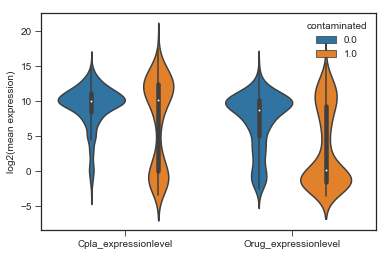

In [48]:
g = sns.violinplot(data=pd.DataFrame(df_genes[[ 'Cpla_expressionlevel',
                                           'Orug_expressionlevel',]].stack().apply(np.log2)
                                ).reset_index(1
                                ).join(df_genes[['contaminated']]
                                ),
               y=0,
               x='level_1',
               hue='contaminated',
               scale='area' # I think area is more appropriate than count, since we want to compare 
                            # the distribution, not the number of genes here.
              )
plt.xlabel("")
plt.ylabel("log2(mean expression)")
plt.show()

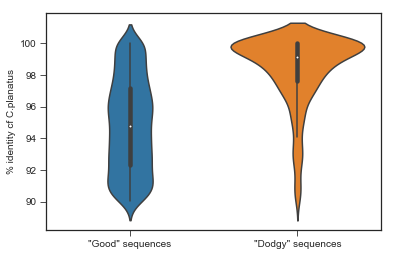

In [49]:
g = sns.violinplot(data=pd.DataFrame(df_genes[[ 'pident_vs_Cpla',
                                           'contaminated',]]
                                ),
                   y='pident_vs_Cpla',
                   x='contaminated',
                   scale='area' 
                  )
plt.xlabel("")
plt.ylabel("% identity cf C.planatus")
plt.xticks([0,1],['"Good" sequences', '"Dodgy" sequences'])
plt.show()

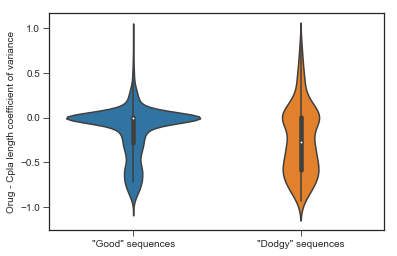

In [50]:
g = sns.violinplot(data=pd.DataFrame(df_genes[[ 'len_coeff',
                                           'contaminated',]]
                                ),
                   y='len_coeff',
                   x='contaminated',
                   scale='area' 
                  )
plt.xlabel("")
plt.ylabel("Orug - Cpla length coefficient of variance")
plt.xticks([0,1],['"Good" sequences', '"Dodgy" sequences'])
plt.show()

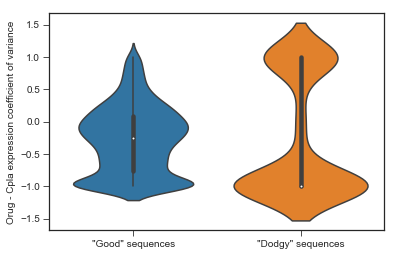

In [51]:
g = sns.violinplot(data=pd.DataFrame(df_genes[[ 'exp_coeff',
                                           'contaminated',]]
                                ),
                   y='exp_coeff',
                   x='contaminated',
                   scale='area' 
                  )
plt.xlabel("")
plt.ylabel("Orug - Cpla expression coefficient of variance")
plt.xticks([0,1],['"Good" sequences', '"Dodgy" sequences'])
plt.show()

In [55]:
#which gene is contaminated?
O_con_ldiff = []
O_con_ediff = []
C_con_ldiff = []
C_con_ediff = []

for ind, row in df_genes.iterrows():
    if row['ctd_sis_taxon'] == 'P' or row['ctd_sis_taxon'] == 'both':
        O_con_ldiff.append(row['len_coeff'])
        O_con_ediff.append(row['exp_coeff'])
    elif row['ctd_sis_taxon'] == 'F' or row['ctd_sis_taxon'] == 'both':
        C_con_ldiff.append(row['len_coeff'])
        C_con_ediff.append(row['exp_coeff'])

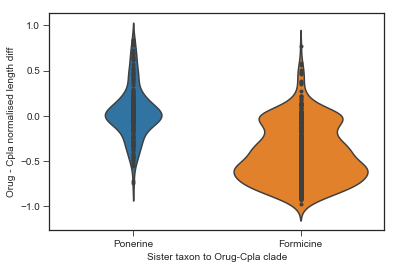

In [56]:
ax9 = sns.violinplot(data = [O_con_ldiff, C_con_ldiff], scale = 'count', inner = 'point')
ax9.set(ylabel = 'Orug - Cpla normalised length diff')
ax9.set_xticklabels(['Ponerine', 'Formicine'])
ax9.set_xlabel('Sister taxon to Orug-Cpla clade')
ax9 = sns.set_style('ticks')

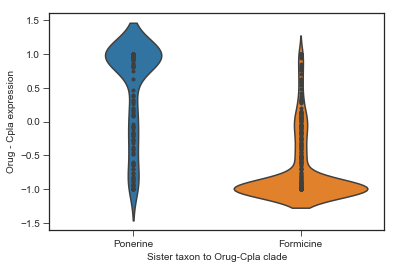

In [57]:
ax10 = sns.violinplot(data = [O_con_ediff, C_con_ediff], scale = 'count', inner = 'point')
ax10.set(ylabel = 'Orug - Cpla expression')
ax10.set_xticklabels(['Ponerine', 'Formicine'])
ax10.set_xlabel('Sister taxon to Orug-Cpla clade')
ax10 = sns.set_style('ticks')

## 6. Identify and remove contaminants from the transcriptome

In [61]:
#make list of contaminant genes that should be removed from the Orug transcriptome
#include genes if contaminated says 1 and if rfdist >= 0.6
genes_for_removal = []
count = 0
c2 = []

for ind, row in df_genes.iterrows():
    if row['class'] == 'Bad':
        genes_for_removal.append(row['Orug_genes'])
    elif row['ctd_sis_taxon'] != 'P' \
        and (row['rfdistance'] >= 0.6 or 
              pd.isnull(row['rfdistance'])
             ) \
        and (row['dist_classification'] == 1 or 
             (row['exp_coeff'] < -0.2 and 
              row['len_coeff'] < -0.2)
             ):
        genes_for_removal.append(row['Orug_genes'])
        count += 1
    elif row['ctd_sis_taxon'] == 'F' and \
         row['exp_coeff'] < -0.2      and  \
         row['len_coeff'] < -0.2:
        genes_for_removal.append(row['Orug_genes'])
        c2.append(row['Orug_genes'])
print(len(genes_for_removal), count, len(c2))

657 566 91


In [63]:
clean_Orug_txome = {}

for key in Orug_txome.keys():
    if key not in genes_for_removal:
        clean_Orug_txome[key] = Orug_txome[key]
  

In [65]:
# filter Orug txome to remove contaminants:
s_clean_Orug_txome = s_Orug_txome[~s_Orug_txome.index.isin(genes_for_removal)]

In [66]:
print(len(s_Orug_txome))
print(len(s_clean_Orug_txome))

26161
25504


In [69]:
#WRITE NEW ORUG TRANSCRIPTOME
with open('clean_Orug_txome.fasta', 'a') as f:
    for geneid in s_clean_Orug_txome.index:
        f.write('>{}\n{}\n'.format(geneid, s_clean_Orug_txome.loc[geneid]))
    f.close()

## 7. Remove contaminant sequences from the Orug htseq counts files

In [51]:
#list htseq count files
Orug_list = []
for file in os.listdir('Orug/'):
    if 'Orug' in file:
        Orug_list.append(file)

In [567]:
for sample in Orug_list:
    fdic = {}
    bad_list = []
    fout = {}
    
    f = pd.read_table(sample, sep = '\t', header = None)
    for ind, row in f.iterrows():
        fdic[row[0]] = row[1]
    
    for key in fdic.keys():
        if 'SGF' in key and key not in clean_Orug_txome.keys():
            bad_list.append(key)
        else:
            fout[key] = fdic[key]

#WRITE TO NEW HTSEQ COUNTS FILE              
#    with open(sample + (str('.clean.txt')), 'a') as i:
#        for key in fout.keys():
#            i.write(str(key) + str('\t') + str(fout[key]) + str('\n'))
#        i.close()

            
